In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
from nanonets import Simulation
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.optimize import curve_fit
from scipy.special import gamma
from scipy.signal import savgol_filter, find_peaks

plt.style.use(["science","bright","grid"])

CPU_CNT     = 32
U0_LIST     = np.linspace(0.01,0.05,CPU_CNT,endpoint=False)
N_VOLT      = 50000
TIME_STEP   = 1e-11
PLOT_NORM   = Normalize(vmin=1000*U0_LIST[0], vmax=1000*U0_LIST[-1])
CMAP        = plt.get_cmap('cividis')
FOLDER      = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/DC/size_volt/"

In [12]:
topo    = {"Nx" : 1, "Ny" : 1, "electrode_type" : ['constant','constant']}
sim_c   = Simulation(topo)
tau_t   = 25*sim_c.get_capacitance_matrix()[0][0]*1e6*1e-9 # in ns
kBT     = 1000 * sim_c.KB_AJ_PER_K * 0.1 / sim_c.ELE_CHARGE_A_C
print(tau_t)
print(kBT)

0.23628021769320412
0.008617333337444407


In [11]:
t   = np.arange(N_VOLT) * TIME_STEP
y   = np.array([pd.read_csv(f"{FOLDER}set_{V:.5f}.csv")['Observable'].values for V in U0_LIST]).T
y   = np.vstack([np.zeros(len(U0_LIST)),y])
y_e = np.array([pd.read_csv(f"{FOLDER}set_{V:.5f}.csv")['Error'].values for V in U0_LIST]).T
y_e = np.vstack([np.zeros(len(U0_LIST)),y_e])

In [22]:
def compute_tau_model_free(t, y, sat_points=1000, peak_fraction=0.995):
    sat_mean    = np.median(y[-sat_points:])
    idx_peak    = np.where(y >= peak_fraction * sat_mean)[0][0]
    t_plot      = t[:idx_peak]
    y_plot      = y[:idx_peak]
    f           = (sat_mean - y_plot) / sat_mean
    norm        = np.trapz(f, x=t_plot)
    if norm <= 0:
        return np.nan
    tau = np.trapz(t_plot * f, x=t_plot) / norm
    return tau

def bootstrap_tau(t, y, y_e, n_boot=2000, sat_points=1000, peak_fraction=0.995):
    sigma   = y_e.copy() / 1.96
    taus    = np.empty(n_boot, dtype=float)
    for k in range(n_boot):
        yb      = y + np.random.normal(loc=0.0, scale=sigma)
        taus[k] = compute_tau_model_free(t, yb, sat_points=sat_points, peak_fraction=peak_fraction)
    taus    = taus[~np.isnan(taus)]
    return taus

In [79]:
skip        = 2
sat_points  = 1000
peak_frac   = 0.7
n_boot      = 2000
taus        = []
for i, V in enumerate(U0_LIST[skip:]):
    # Copy data
    t_copy      = t.copy()*1e9
    y_copy      = (y[:,i+skip].copy()*1e-9)/V
    y_e_copy    = (y_e[:,i+skip].copy()*1e-9)/V

    # Bootstrap tau values
    tau = bootstrap_tau(t_copy, y_copy, y_e_copy, n_boot, sat_points, peak_frac)
    taus.append(tau)
taus = np.array(taus)

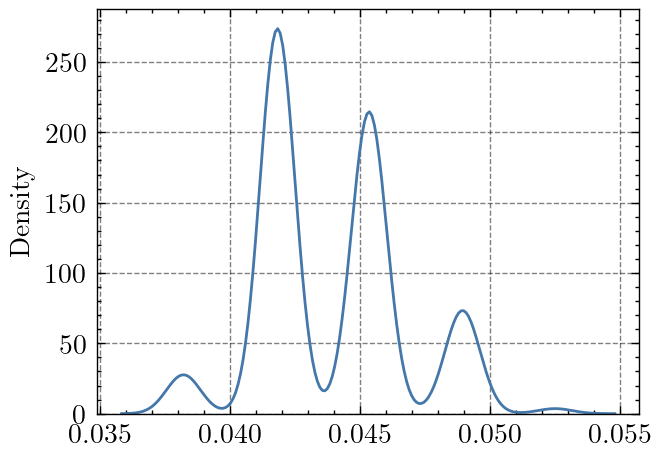

In [80]:
fig, ax = plt.subplots(dpi=200)
ax  = sns.kdeplot(taus[24,:])
# ax.set_xlim(0.1,0.3)

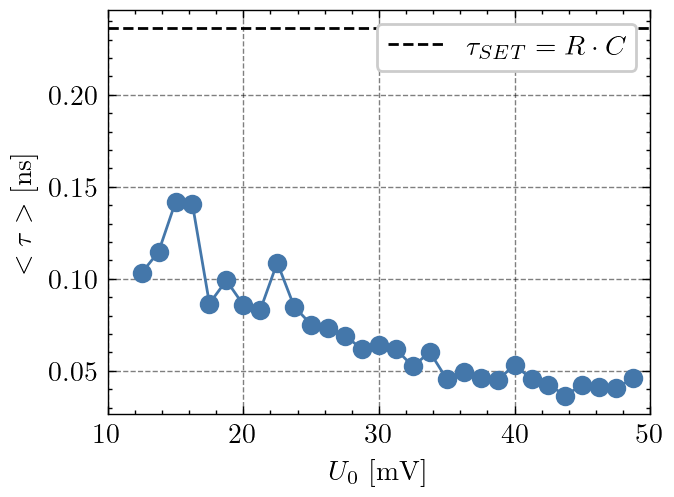

In [81]:
V_write     = np.array(U0_LIST[skip:])*1000
tau_mean    = np.median(np.array(taus), axis=1)
tau_std     = np.std(np.array(taus), axis=1)

fig, ax = plt.subplots(dpi=200)
_ = ax.plot(V_write, tau_mean, marker='o')
# _ = ax.errorbar(V_write, tau_mean, tau_std, marker='o')
_ = ax.hlines(tau_t, 10, 50, colors='black', label='$\\tau_{SET} = R \cdot C$', ls='--')
_ = ax.legend()
_ = ax.set_xlabel("$U_0$ [mV]")
_ = ax.set_ylabel("$<\\tau>$ [ns]")
_ = ax.set_xlim(10, 50)

In [ ]:
skip        = 2
min_con     = 5
sat         = 1000
p_sat       = 0.9
taus        = []
cvs         = []
# idx_peak    = [0,0,80,80,80,85,100,60,80,40,60,50,60,100,60,50,60,40,50,40,30,50,30,30,50,60,60,45,55,60,40,40]
idx_peak    = [0,0,100,100,100,85,70,70,70,60,60,60,60,60,60,60,60,50,50,50,50,50,50,50,50,50,50,50,50,50,40,40]
idx_peak    = np.repeat(100,32) #[0,0,80,80,80,85,100,60,80,40,60,50,60,100,60,50,60,40,50,40,30,50,30,30,50,60,60,45,55,60,40,40
idx_values  = np.arange(10,200,1)
for i, V in enumerate(U0_LIST[skip:]):

    # Copy data
    t_copy  = t.copy()*1e9
    y_copy  = (np.round(y[:,i+skip].copy()*1e-9,2))/V

    # Get Saturation Values and Transient Part
    sat_mean = np.median(y_copy[-sat:])
    tau_tmp = []
    cv_tmp  = []
    for idx_val in idx_values:
    # idx_val  = np.where(y_copy>sat_mean)[0][0]

    # t_plot  = t_copy[:int(1.0*idx_peak[i+skip])]
    # y_plot  = y_copy[:int(1.0*idx_peak[i+skip])]

        t_plot  = t_copy[:idx_val]
        y_plot  = y_copy[:idx_val]
        
        # Get Tau and CV (model-free)
        f       = (sat_mean - y_plot) / sat_mean
        norm    = np.trapz(f, x=t_plot)
        tau     = np.trapz(t_plot * f, x=t_plot) / norm
        tau2    = np.trapz(t_plot**2 * f, x=t_plot) / norm
        sigma   = np.sqrt(tau2 - tau**2)
        cv      = sigma / tau
        tau_tmp.append(tau)
        cv_tmp.append(cv)

    # Append
    taus.append(tau_tmp)
    cvs.append(cv_tmp)

/tmp/ipykernel_1901/844246722.py:37: RuntimeWarning: invalid value encountered in sqrt
  sigma   = np.sqrt(tau2 - tau**2)


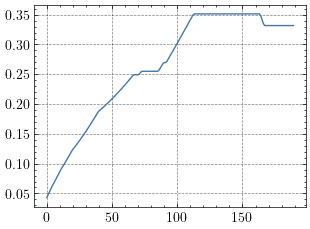

In [327]:
plt.plot(taus[1])

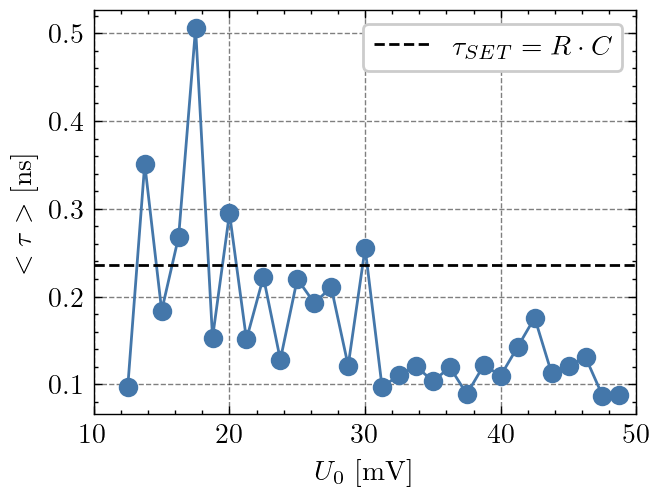

In [296]:
def power_law(x, A, k, V_th):
    return A*(x-V_th)**(-k)

V_max       = 50
V_write     = np.array(U0_LIST[skip:])*1000
V_clean     = V_write[V_write < V_max]
tau_clean   = np.array(taus)[V_write < V_max]
p, cov      = curve_fit(power_law, V_clean, tau_clean, bounds=[[0,0,0],[np.inf,np.inf,20]])
V_fit       = np.linspace(10, 50, 100)
tau_fit     = power_law(V_fit, *p)

fig, ax = plt.subplots(dpi=200)
_ = ax.plot(np.array(U0_LIST[skip:])*1000, taus, '-o')#, label='$<\\tau> = \\frac{\\tau_K}{\\beta}\\Gamma(\\frac{1}{\\beta})$')
# _ = ax.plot(V_fit, tau_fit, label='$<\\tau>\\propto (U_0 - U_{th})^{-k}$\n$U_{th} = '+f'{p[2].round(1)}$ mV, $k = {p[1].round(1)}$')
_ = ax.hlines(tau_t, 10, 50, colors='black', label='$\\tau_{SET} = R \cdot C$', ls='--')
_ = ax.legend()
_ = ax.set_xlabel("$U_0$ [mV]")
_ = ax.set_ylabel("$<\\tau>$ [ns]")
_ = ax.set_xlim(10, 50)

# fig.savefig(f"plots/png/DC/N={N_PARTICLES}_N={N_PARTICLES}_tau_vs_U.png", transparent=False)
# fig.savefig(f"plots/pdf/DC/N={N_PARTICLES}_N={N_PARTICLES}_tau_vs_U.pdf", transparent=False)
# fig.savefig(f"plots/svg/DC/N={N_PARTICLES}_N={N_PARTICLES}_tau_vs_U.svg", transparent=True)

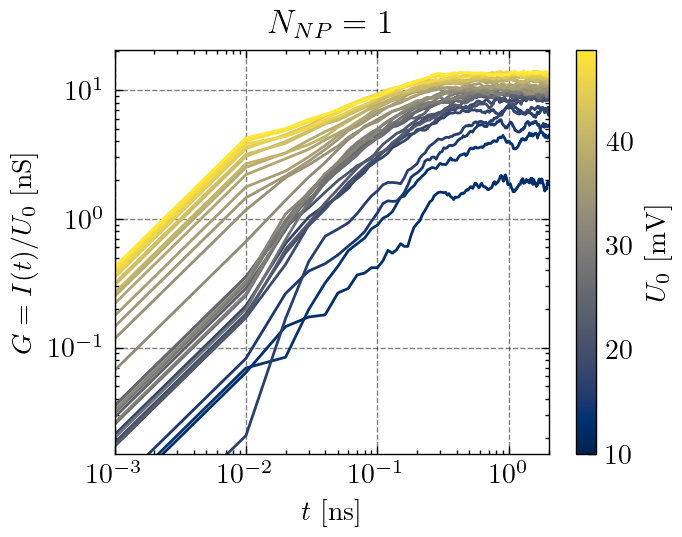

In [304]:
fig, ax = plt.subplots(dpi=200)
for i, V in enumerate(U0_LIST):
    t_copy  = t.copy()*1e9
    y_copy  = (np.round(y[:,i].copy()*1e-9,6))/V
    ax.plot(t_copy, y_copy, color=CMAP(PLOT_NORM(V*1000)))
    
_ = ax.set_xlabel("$t$ [ns]")
_ = ax.set_ylabel("$G = I(t)/U_0$ [nS]")
_ = ax.set_xlim(0.001, 200*TIME_STEP*1e9)
# _ = ax.set_ylim(0, 2.0)
_ = ax.set_title("$N_{NP} = 1$")
_ = ax.set_xscale('log')
_ = ax.set_yscale('log')
sm  = ScalarMappable(cmap=CMAP, norm=PLOT_NORM)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$U_0$ [mV]")

# fig.savefig(f"plots/png/relaxation/N={N_NP}_N={N_NP}_G_vs_t.png", transparent=False)
# fig.savefig(f"plots/pdf/relaxation/N={N_NP}_N={N_NP}_G_vs_t.pdf", transparent=False)
# fig.savefig(f"plots/svg/relaxation/N={N_NP}_N={N_NP}_G_vs_t.svg", transparent=True)

In [219]:
idx_peak = [0,0,100,100,100,85,100,60,80,40,60,50,60,100,60,50,60,40,50,40,30,50,30,30,50,60,60,45,55,60,40,40]
idx_peak = [0,0,100,100,100,85,70,70,70,60,60,60,60,60,60,60,60,50,50,50,50,50,50,50,50,50,50,50,50,50,40,40]
len(idx_peak)

32

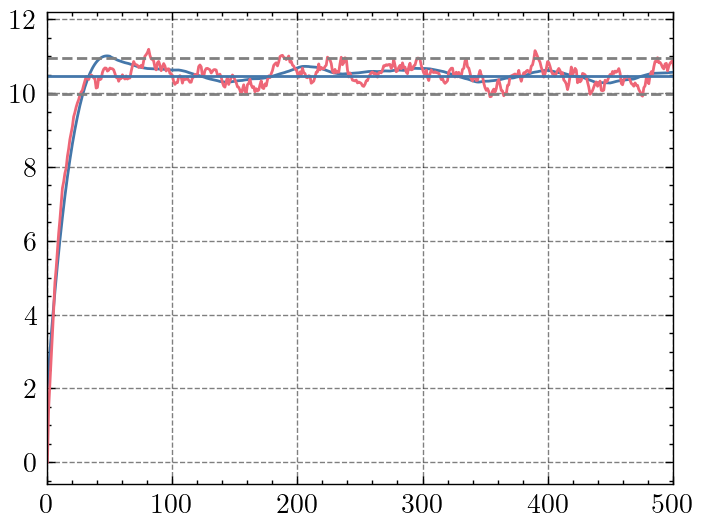

In [294]:
i       = 20
v_max   = 500
y_copy  = (y[:,i].copy()*1e-9)/U0_LIST[i]
fig     = plt.figure(dpi=200, layout='constrained')
ax = fig.add_subplot()
ax.plot(savgol_filter(y_copy, polyorder=3, window_length=101, mode='interp'))
ax.plot(y_copy)
ax.hlines(np.median(y_copy[:-1000]),0,v_max)
ax.hlines(np.quantile(y_copy[:-1000],0.05),0,v_max, color='grey', ls='dashed')
ax.hlines(np.quantile(y_copy[:-1000],0.95),0,v_max, color='grey', ls='dashed')
_ = ax.set_xlim(0, v_max)

# ax = fig.add_subplot(1,2,2)
# ax.plot(savgol_filter(y_copy, polyorder=3, window_length=101))
# ax.plot(y_copy)
# ax.hlines(np.median(y_copy[:-1000]),0,v_max)
# ax.hlines(np.quantile(y_copy[:-1000],0.05),0,v_max, color='grey', ls='dashed')
# ax.hlines(np.quantile(y_copy[:-1000],0.95),0,v_max, color='grey', ls='dashed')
# _ = ax.set_xlim(40000,50000)
# _ = ax.set_ylim(10, 12)